# Tutorial for the computation of Activation Free Energies

### Imports

In [1]:
import sys
sys.path.append('./Adaptive_Sampling')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import pandas as pd
import seaborn as sns

font = {'family': 'serif',
        'weight': 'normal',
        'size': 22,
        }

import torch

In [3]:
from ase import io
import mdtraj

In [4]:
# MBAR for eABF simulations from https://github.com/ochsenfeld-lab/adaptive_sampling
# Andreas Hulm, Johannes C. B. Dietschreit, and Christian Ochsenfeld , 
# "Statistically optimal analysis of the extended-system adaptive biasing force (eABF) method", 
# J. Chem. Phys. 157, 024110 (2022) https://doi.org/10.1063/5.0095554

from adaptive_sampling.processing_tools import mbar
from adaptive_sampling.processing_tools.utils import *
from adaptive_sampling import units

### Explicit definition of central functions

In [5]:
# The following two functions can be found at 
# https://github.com/ochsenfeld-lab/adaptive_sampling/blob/main/adaptive_sampling/processing_tools/utils.py
# but they are given here explicitly for easier understanding

# all calculations are done in SI units
# - mxi_inv has the unit of [CV-unit / (Angstrom^2 * a.m.u.)],
#   therefore the factors of atomic_to_kg and 1e10 to adjust to [CV-unit / (m^2 * kg)],
#   then lambda has the unit of [CV-unit]
# - rho has the unit of [CV-unit^{-1}]
# - Hence, rho*lambda is dimensionless
# - P(A) is a probility and therefore also dimensionless


def reaction_freeE(
    pmf: np.ndarray,
    T: float = 300.0,
    min_bin: int = 20,
    max_bin: int = -20,
    TS: int = None,
) -> tuple:
    """calculate free energy difference
       see: Dietschreit et al., J. Chem. Phys. 156, 114105 (2022); https://doi.org/10.1063/5.0083423

    Args:
        pmf: potential of mean force (free energy surface)
        T: temperature
        min_bin/max_bin: minimum/maximum bin for search of transition state
        TS: alternatively, bin number of TS

    Returns:
        dA (float): free energy difference
        dA_grid (np.ndarray): free energy difference on grid
    """
    RT = (R_in_SI * T) / 1000.0
    pmf = pmf[~np.isnan(pmf)]

    if TS == None:
        TS = np.where(pmf == np.amax(pmf[min_bin:max_bin]))[0][0]

    P = np.exp(-pmf / RT)
    P /= P.sum()

    P_a = P[:TS].sum()
    P_b = P[(TS + 1) :].sum()

    dA = RT * np.log(P_a / P_b)
    dA_grid = np.zeros(len(pmf))
    dA_grid[TS] += dA / 2
    dA_grid[(TS + 1) :] += dA
    dA_approx = pmf[TS:].min() - pmf[:TS].min()

    return dA, dA_grid, dA_approx


def activation_freeE(
    pmf: np.ndarray,
    m_xi_inv: np.ndarray,
    T: float = 300.0,
    min_bin: int = 20,
    max_bin: int = -20,
    TS: int = None,
) -> tuple:
    """calculate activation free energy
       see: Dietschreit et al., J. Chem. Phys. XX, XXX (2022); https://doi.org/XXXX

    Args:
        pmf: potential of mean force (free energy surface)
        m_xi_inv: z-conditioned average of inverse mass associates with CV, expected units are xi^2/(au_mass * angstrom^2)
        T: temperature
        min_bin/max_bin: minimum/maximum bin for search of transition state
        TS: alternatively, bin number of TS

    Returns:
        dA (float): free energy difference
        dA_grid (np.ndarray): free energy difference on grid
    """
    RT = (R_in_SI * T) / 1000.0  # kJ/mol

    pmf = pmf[~np.isnan(pmf)]
    if TS == None:
        TS = np.where(pmf == np.amax(pmf[min_bin:max_bin]))[0][0]

    rho = np.exp(-pmf / RT)
    P = rho / rho.sum()  # normalize so that P_a + P_b = 1.0

    lambda_xi = np.sqrt(
        (h_in_SI * h_in_SI * m_xi_inv[TS]) / (2.0 * np.pi * atomic_to_kg * kB_in_SI * T)
    )
    lambda_xi *= 1e10 # to adjust from Angstrom to meter

    P_a = P[:TS].sum()
    P_b = P[(TS + 1) :].sum()

    dA_a2b = -RT * np.log((rho[TS] * lambda_xi) / P_a)
    dA_b2a = -RT * np.log((rho[TS] * lambda_xi) / P_b)
    dA_a2b_approx = pmf[TS] - pmf[:TS].min()
    dA_b2a_approx = pmf[TS] - pmf[TS:].min()

    return dA_a2b, dA_b2a, dA_a2b_approx, dA_b2a_approx

In [6]:
# Collective variable class
# computes CV value and gradient of CV wrt Cartesian coordinates

class CV:
    def __init__(self, Masses):
        self._xi = torch.tensor(0.0)
        self._xi.requires_grad = True
        
        self.Na   = len(Masses)
        self.Minv = torch.diag(torch.tensor([1/Masses, 1/Masses, 1/Masses]).T.flatten())
        self.Minv = self.Minv.type(torch.FloatTensor)
        self.gradxi = torch.zeros(3*self.Na)
        self.mxi_inv  = torch.tensor(0.0)
        
    # getter function
    @property
    def xi(self):
        return self._xi
       
    # setter function
    @xi.setter
    def xi(self, coords):
        # Cartesian coordinates
        coords = torch.from_numpy(coords)
        coords = coords.type(torch.FloatTensor)
        coords.requires_grad = True
        
        carbon1 = coords[9]
        carbon2 = coords[12]
        
        self._xi = torch.linalg.norm(carbon1 - carbon2)
        
        # calling gradient on the CV
        self._xi.backward()
        
        # getting the Cartesian gradient of the CV
        grad = coords.grad
        self.gradxi = grad.flatten()
        
        # inverse CV mass, eq. (27) in the paper
        self.mxi_inv = torch.dot(self.gradxi, torch.matmul(self.Minv, self.gradxi))
          

### Loading and analyzing data

In [7]:
# trajectory of coordinates
coord_traj = mdtraj.load_dcd('hexanyl_traj.dcd', top='hexanyl_reference.pdb')
reference  = io.read("hexanyl_reference.pdb")

# computing CV value and inverse CV mass for all frames
# Note: this is just for educational purposes,
#       the MD output contains both values 
n_frames = len(coord_traj)
cvs      = np.zeros(n_frames)
mxi_inv  = np.zeros(n_frames) 

theCV = CV(reference.get_masses())

for ii, frame in enumerate(coord_traj):
    theCV.xi    = frame._xyz[0]*10.0 # the mdtraj unit is nm not Angstrom
    cvs[ii]     = theCV.xi
    mxi_inv[ii] = theCV.mxi_inv

In [8]:
# loading the output file of the AIMD
# The file contains the columns:
# 0) timestep 1) CV value 2) extended variable 3) potential energy
# 4) temperature 5) inverse CV mass 6) length of Epot gradient
# 7) length of CV gradient 8) scalar product <grad Epot, grad CV>
traj = np.loadtxt('hexanyl_wB97mv_tzvp.dat', skiprows=1)

In [9]:
# Short check that CVs calculated here and the outputfile of the MD are identical
print("CV values")
print("computed here")
print(f"{cvs[0]:1.2f}")
print("MD output")
print(f"{traj[0,1]:1.2f}")
print("-------------------")
print("\ninverese CV mass")
print("computed here")
print(f"{mxi_inv[0]:1.5f}")
print("MD output")
print(f"{traj[0, 5]:1.5f}")

CV values
computed here
1.52
MD output
1.52
-------------------

inverese CV mass
computed here
0.16651
MD output
0.16651


In [10]:
# coupling width of the eABF simulation, 
# do not change this! this is the value from the simulation
sigma = 0.05

# parameters for the grid for which the trajectory
# is split into fictional umbrella windows
dxi = sigma 
min_xi = 1.0
max_xi = 6.0
grid = np.arange(min_xi, max_xi, dxi)

# this function needs the CV-values and the coupled extended variable
traj_list, indices, meta_f = mbar.get_windows(grid, traj[:,1], traj[:,2], sigma, equil_temp=300.0)

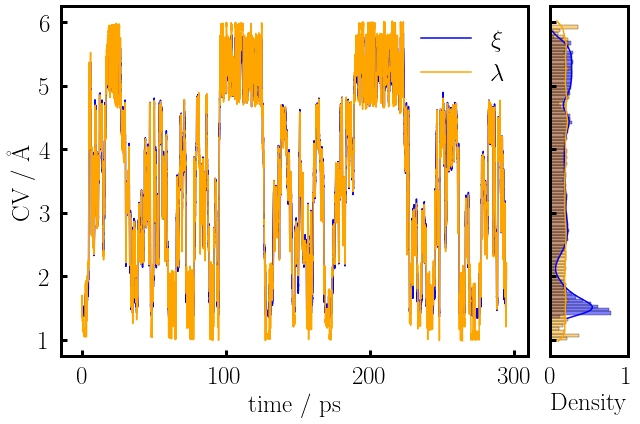

In [11]:
# checking how well CV was sampled
timestep_ps = 0.5/1000
data = {'ps': np.arange(0,len(traj[:,1])*timestep_ps, timestep_ps), 't': traj[:,0], 'cv': traj[:,1], 'la': traj[:,2]}
df = pd.DataFrame(data)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(9,6), gridspec_kw=dict(width_ratios=[3,0.5]))

sns.lineplot(data=df, y='cv', x='ps', ax=axs[0], label=r'$\xi$', color='blue')
sns.lineplot(data=df, y='la', x='ps', ax=axs[0], label=r'$\lambda$', color='orange')
sns.histplot(data=df, y='cv', bins=grid, ax=axs[1], stat='density', kde=True, color='blue')
sns.histplot(data=df, y='la', bins=grid, ax=axs[1], stat='density', kde=True, color='orange')

axs[0].set_xlabel('time / ps', fontsize=25)
axs[0].set_ylabel('CV / \AA', fontsize=25)
axs[0].set_ylim([0.75,6.25])
axs[0].legend(fontsize=25, frameon=False)
axs[1].set_xlabel('Density', fontsize=25)
axs[1].set_xlim([0,1])

for ax in axs:
    ax.tick_params(axis='x',length=6,width=3,labelsize=25, pad=10, direction='in')
    ax.tick_params(axis='y',length=6,width=3,labelsize=25, pad=10, direction='in')
    ax.spines['bottom'].set_linewidth('3')
    ax.spines['top'].set_linewidth('3')
    ax.spines['left'].set_linewidth('3')
    ax.spines['right'].set_linewidth('3')

fig.tight_layout()
plt.show()

### Getting unbiased weights for all frames

In [19]:
# # statistical weights of data points and PMF obtained from MBAR
# W = mbar.run_mbar(traj_list, meta_f, equil_temp=300.0, outfreq=50, conv = 1.0e-6, max_iter=int(1e6))
# # save weights
# np.save("umbrella_weights.npy", W)

Making Boltzmann factors

All ready!

Start of the self-consistent iteration.
Iter    1:	Conv= 30.4800133917	Conv_errvec=   9430.261926
Iter   50:	Conv=  0.2070275272	Conv_errvec=   1049.368500
Iter  100:	Conv=  0.0895678456	Conv_errvec=    416.815753
Iter  150:	Conv=  0.0551327660	Conv_errvec=    281.068495
Iter  200:	Conv=  0.0385075113	Conv_errvec=    209.839535
Iter  250:	Conv=  0.0280206863	Conv_errvec=    165.184783
Iter  300:	Conv=  0.0211397687	Conv_errvec=    134.763737
Iter  350:	Conv=  0.0168903663	Conv_errvec=    113.086837
Iter  400:	Conv=  0.0144426265	Conv_errvec=     97.120549
Iter  450:	Conv=  0.0127446049	Conv_errvec=     85.006353
Iter  500:	Conv=  0.0115172297	Conv_errvec=     75.554290
Iter  550:	Conv=  0.0105888210	Conv_errvec=     67.984787
Iter  600:	Conv=  0.0098529938	Conv_errvec=     61.778129
Iter  650:	Conv=  0.0092435885	Conv_errvec=     56.581795
Iter  700:	Conv=  0.0087193417	Conv_errvec=     52.152188
Iter  750:	Conv=  0.0082544231	Conv_errvec=     48.3

Iter 6950:	Conv=  0.0000196281	Conv_errvec=      0.098092
Iter 7000:	Conv=  0.0000186957	Conv_errvec=      0.093432
Iter 7050:	Conv=  0.0000178077	Conv_errvec=      0.088994
Iter 7100:	Conv=  0.0000169618	Conv_errvec=      0.084767
Iter 7150:	Conv=  0.0000161561	Conv_errvec=      0.080741
Iter 7200:	Conv=  0.0000153887	Conv_errvec=      0.076905
Iter 7250:	Conv=  0.0000146578	Conv_errvec=      0.073252
Iter 7300:	Conv=  0.0000139615	Conv_errvec=      0.069773
Iter 7350:	Conv=  0.0000132983	Conv_errvec=      0.066459
Iter 7400:	Conv=  0.0000126667	Conv_errvec=      0.063302
Iter 7450:	Conv=  0.0000120650	Conv_errvec=      0.060295
Iter 7500:	Conv=  0.0000114919	Conv_errvec=      0.057431
Iter 7550:	Conv=  0.0000109461	Conv_errvec=      0.054703
Iter 7600:	Conv=  0.0000104261	Conv_errvec=      0.052105
Iter 7650:	Conv=  0.0000099309	Conv_errvec=      0.049630
Iter 7700:	Conv=  0.0000094592	Conv_errvec=      0.047272
Iter 7750:	Conv=  0.0000090099	Conv_errvec=      0.045027
Iter 7800:	Con

In [12]:
# load weights
W = np.load("umbrella_weights.npy")

In [13]:
# get PMF and density
A_mbar, rho_mbar = mbar.pmf_from_weights(grid, traj[:,1][indices], W, equil_temp=300.0)

In [14]:
# Calculate CV criterion from eq. (45)
# it is a CV-conditioned ensemble average
Ds , _= conditional_average(grid, 
                            traj[:,1][indices], 
                            (np.abs(traj[:,8])/(np.multiply(traj[:,6], traj[:,7])))[indices], 
                            W)

# Calculate CV inv mass aslong CV values
# it is a CV-conditioned ensemble average
mxi_inv, _ = conditional_average(grid, 
                                 traj[:,1][indices], 
                                 traj[:,5][indices], 
                                 W)

# The mask is important to highlight bins without samples
mask = (Ds==0)
Ds[mask] = np.nan
A_mbar[mask] = np.nan

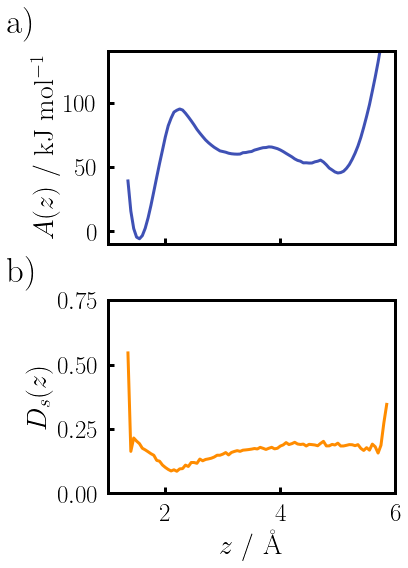

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(6,8), sharex=True)

axs[0].plot(grid, A_mbar, linewidth=3, color="#3f51b5")
axs[1].plot(grid, Ds, linewidth=3, color="darkorange")

axs[0].set_ylim([-10,140])
axs[1].set_ylim([0.0, 0.75])
axs[0].set_xlim([1.0,6.0])
axs[1].set_xlabel(r'$z$ / \AA', fontsize=28)
axs[0].set_ylabel(r'$A(z)$ / kJ mol$^{-1}$', fontsize=28)
axs[1].set_ylabel(r'$D_s(z)$', fontsize=28)

labels = ['a)', 'b)']
for ii, ax in enumerate(axs):
    ax.tick_params(axis='y',length=6,width=3,labelsize=25, pad=10, direction='in')
    ax.tick_params(axis='x',length=6,width=3,labelsize=25, pad=10, direction='in')
    ax.spines['bottom'].set_linewidth('3')
    ax.spines['top'].set_linewidth('3')
    ax.spines['left'].set_linewidth('3')
    ax.spines['right'].set_linewidth('3')


axs[0].text(-0.35, 1.05, labels[0], transform=axs[0].transAxes,
            fontsize=35, va='bottom', fontfamily='serif')
axs[1].text(-0.35, 1.05, labels[1], transform=axs[1].transAxes,
            fontsize=35, va='bottom', fontfamily='serif')
    
fig.tight_layout()

plt.show()

In [16]:
DeltaA, _, DeltaA_approx = reaction_freeE(A_mbar, T = 300.0)
DAact_forw, DAact_backw, DAact_forw_approx, DAact_backw_approx = activation_freeE(A_mbar, mxi_inv, T = 300.0)

In [17]:
print(f"The reaction free energy is: {DeltaA:2.1f} kJ/mol.")
print(f"The difference between the minima on the PMF is: {DeltaA_approx:2.1f} kJ/mol.")

print(f"\nThe ring opening activation free energy is: {DAact_forw:3.1f} kJ/mol.")
print(f"The difference between the maximum and left minimum on the PMF is: {DAact_forw_approx:3.1f} kJ/mol.")

print(f"\nThe ring closure activation free energy is: {DAact_backw:3.1f} kJ/mol.")
print(f"The difference between the maximum and right minimum on the PMF is: {DAact_backw_approx:3.1f} kJ/mol.")

The reaction free energy is: 49.1 kJ/mol.
The difference between the minima on the PMF is: 51.1 kJ/mol.

The ring opening activation free energy is: 94.0 kJ/mol.
The difference between the maximum and left minimum on the PMF is: 97.5 kJ/mol.

The ring closure activation free energy is: 44.9 kJ/mol.
The difference between the maximum and right minimum on the PMF is: 46.4 kJ/mol.
